# Balancing and Distinguishing the Minority Class: A Comprehensive Investigation and Final Model

## Introduction
This notebook is dedicated to constructing a robust machine learning model aimed at accurately predicting true positives within a highly imbalanced dataset that also features a high degree of missing values. Our approach includes a series of systematic steps ranging from data preprocessing and feature engineering to advanced model tuning techniques. The ultimate goal is to enhance the model's ability to handle skewed data distributions effectively.

## Data Characteristics
- Imbalance in Class Distribution: The dataset exhibits a significant skew, with the minority (positive) class comprising only 10% of the total observations.
- Prevalence of Missing Values: A notable challenge is that approximately 92% of the dataset entries contain missing values, which requires the implementation of robust imputation strategies.

## Implemented Steps and Techniques
1. Data Cleaning and Preprocessing: Initial steps to prepare the data for analysis, including filtering out irrelevant features (missing data greater than 95%) and correcting anomalies.
2. Missing Value Imputation: Techniques to handle and fill gaps in the dataset, ensuring that the model receives comprehensive data inputs.
3. Data Standardization: Normalizing data to reduce bias due to differing scales among features.
4. Feature Selection via Variance Threshold: Removing low-variance features to improve model efficiency and focus on relevant predictors.
5. Dimensionality Reduction: Techniques such as PCA to reduce the number of variables under consideration, focusing on those that most contribute to variance in the dataset.
6. SMOTE (Synthetic Minority Over-sampling Technique): Addressing class imbalance by artificially augmenting the minority class in the training set.
7. Model Training with LightGBM: Leveraging LightGBM for its efficiency and effectiveness, with a focus on hyperparameter tuning and regularization to optimize performance.
8. Iterative Model Evaluation: Continuously comparing enhancements against a baseline model to measure improvement.

## Conclusion
By the end of this notebook, we will evaluate our model's performance on the test set and compare it against the baseline results. This final assessment will highlight the effectiveness of the implemented techniques in addressing class imbalance and missing data, ultimately guiding us toward more accurate and reliable predictive modeling.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_iterative_imputer  # Required to enable the IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_val_score

from lightgbm import LGBMClassifier
from sklearn.model_selection import GroupKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, KFold
from sklearn.metrics import confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import os
import warnings
import mlflow
import joblib
warnings.filterwarnings('ignore')

In [0]:
mlflow.autolog(disable=True)

# Load the data

We will use the union of the personal and non personal data after begin preprocessed. In this stage we will use just a set of that. This same code will be later run again with the complete dataset to get the final scores on the complete data.

In [0]:
path1='/dbfs/FileStore/LEM_TEST/df1.pkl'
path2='/dbfs/FileStore/LEM_TEST/df2.pkl'

# Read the pickle files into pandas DataFrames
df1 = pd.read_pickle(path1)
df2 = pd.read_pickle(path2)

# Joing the applicant personal data and the non personal one to get the complete dataset.
df_full = df1.merge(df2, on=['case_id', 'date_decision', 'WEEK_NUM'], how='left')

# dropping the extra target column that appeared because of the join and it is just a duplicate of the target
df_full.rename(columns={'target_x': 'target'}, inplace=True)

# Drop target_y
df_full.drop(columns=['target_y'], inplace=True)

In [0]:
print('Train dataset shape', df_full.shape)


Train dataset shape (10000, 2638)


In [0]:
# Inspecting the dataset 
df_full.head()

,case_id,date_decision,MONTH_x,WEEK_NUM,target,empls_employedfrom_796D_distinct_x,empls_employedfrom_796D_min_year_x,empls_employedfrom_796D_min_month_x,empls_employedfrom_796D_min_day_x,empls_employedfrom_796D_max_year_x,empls_employedfrom_796D_max_month_x,empls_employedfrom_796D_max_day_x,addres_district_368M_freq_x,addres_role_871L_freq_x,addres_zip_823M_freq_x,conts_role_79M_freq_x,empls_economicalst_849M_freq_x,empls_employer_name_740M_freq_x,relatedpersons_role_762T_freq_x,addres_district_368M_binary_0_x,addres_district_368M_binary_1_x,addres_district_368M_binary_2_x,addres_district_368M_binary_3_x,addres_district_368M_binary_4_x,addres_district_368M_binary_5_x,addres_district_368M_binary_6_x,addres_district_368M_binary_7_x,addres_district_368M_binary_8_x,addres_role_871L_binary_0_x,addres_role_871L_binary_1_x,addres_zip_823M_binary_0_x,addres_zip_823M_binary_1_x,addres_zip_823M_binary_2_x,addres_zip_823M_binary_3_x,addres_zip_823M_binary_4_x,addres_zip_823M_binary_5_x,addres_zip_823M_binary_6_x,addres_zip_823M_binary_7_x,addres_zip_823M_binary_8_x,addres_zip_823M_binary_9_x,...,collater_typofvalofguarant_298M_binary_0_y,collater_typofvalofguarant_298M_binary_1_y,collater_typofvalofguarant_407M_binary_0_y,collater_typofvalofguarant_407M_binary_1_y,collaterals_typeofguarante_359M_binary_0_y,collaterals_typeofguarante_359M_binary_1_y,collaterals_typeofguarante_359M_binary_2_y,collaterals_typeofguarante_669M_binary_0_y,collaterals_typeofguarante_669M_binary_1_y,collaterals_typeofguarante_669M_binary_2_y,subjectroles_name_541M_binary_0_y,cacccardblochreas_147M_freq_y,conts_type_509L_freq_y,credacc_cards_status_52L_freq_y,cacccardblochreas_147M_binary_0_y,cacccardblochreas_147M_binary_1_y,cacccardblochreas_147M_binary_2_y,conts_type_509L_binary_0_y,conts_type_509L_binary_1_y,conts_type_509L_binary_2_y,credacc_cards_status_52L_binary_0_y,credacc_cards_status_52L_binary_1_y,credacc_cards_status_52L_binary_2_y,pmts_dpdvalue_108P_min_y,pmts_pmtsoverdue_635A_min_y,pmts_dpdvalue_108P_max_y,pmts_pmtsoverdue_635A_max_y,pmts_dpdvalue_108P_mean_y,pmts_pmtsoverdue_635A_mean_y,pmts_dpdvalue_108P_median_y,pmts_pmtsoverdue_635A_median_y,pmts_dpdvalue_108P_sum_y,pmts_pmtsoverdue_635A_sum_y,pmts_date_1107D_distinct_y,pmts_date_1107D_min_year_y,pmts_date_1107D_min_month_y,pmts_date_1107D_min_day_y,pmts_date_1107D_max_year_y,pmts_date_1107D_max_month_y,pmts_date_1107D_max_day_y
0,1488310,2019-08-14,201908,32,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.99174,NaN,0.991968,0.993043,0.993195,0.999999,NaN,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.986718,0.68935,NaN,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13904,2019-05-06,201905,17,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.99174,NaN,0.991968,0.993043,0.993195,0.999999,NaN,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,783503,2019-08-28,201908,34,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.99174,NaN,0.991968,0.993043,0.993195,0.999999,NaN,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.986718,0.68935,NaN,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,17986,2019-06-09,201906,22,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.99174,NaN,0.991968,0.993043,0.993195,0.999999,NaN,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1400855,2019-06-13,201906,23,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.99174,NaN,0.991968,0.993043,0.993195,0.999999,NaN,1.0,0.0,1.0,0.0,1.0,0.0,0.

# 1. Data Cleaning after pre-processing

We futher clean the data to be able to feed Machime Learning models and to apply the neccessary transformations.
 - Boolean Columns:
The boolean columns are filled with False where None is present, and then converted to boolean type using .astype(bool).
- Object Columns:
The object columns, which contain None, True, or False, are replaced with np.nan, 1.0, or 0.0 respectively, and converted to float.

In [0]:
# Convert date_decision to timestamp
df_full["date_decision"] = pd.to_datetime(df_full["date_decision"]).astype('int64') / 10**9

# Get boolean columns from df_full
bool_columns = df_full.select_dtypes(include=['bool']).columns.tolist()

for col in bool_columns:
    df_full[col] = df_full[col].fillna(False).astype(bool)

# Get object columns from df_full
object_columns = df_full.select_dtypes(include=['object']).columns.tolist()

for col in object_columns:
    df_full[col] = df_full[col].replace({None: np.nan, True: 1.0, False: 0.0})


## Removing Columns where Missing data is more than 95% 

In [0]:
# Remove columns with more than 95% missing values
missing_threshold = 0.95
df_filtered = df_full[df_full.columns[df_full.isnull().mean() < missing_threshold]]

Check the shapes of the dataset pre and post change

In [0]:
print('Shape training dataset before missing threshold', df_full.shape)
print('Shape training dataset after missing threshold', df_filtered.shape)

Shape training dataset before missing threshold (10000, 2638)
Shape training dataset after missing threshold (10000, 1879)


## Train, Validation and Test Split. 

We remove the target from the training datasets. We split on train and test set. We then further split the dataset into train and validation. For this split we will startify based on the target so we ge the same proportion on positives clases in both splits

In [0]:
# Initial split to separate out the test dataset
df_train, df_test = train_test_split(df_filtered, test_size=0.2, random_state=1)

# Initial split to separate out the test dataset
df_train, df_test = train_test_split(df_filtered, test_size=0.2, random_state=1)

# Get features and target
X_test = df_test.drop(columns=["case_id", "WEEK_NUM", "target"])
y_test = df_test["target"]

X = df_train.drop(columns=["case_id", "WEEK_NUM", "target"])
y = df_train["target"]

#  Train and Validation split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, random_state=1, stratify=y)

# 2. Missing Value Imputation Strategies

Handling missing data is a critical step in preparing our dataset for effective modeling. Incomplete data can significantly distort the predictive model’s performance if not addressed properly. To tackle this, we will explore multiple imputation techniques, each followed by a thorough evaluation of its impact on model performance.

### Imputation Techniques to be Explored:
1. KNN Imputation:

We will employ KNN imputation, which predicts missing values using the mean or median of the k-nearest neighbors found in the training set. Two configurations will be tested:
    - 5 Neighbors: A tighter cluster which may capture more localized data patterns.
    - 10 Neighbors: A broader cluster to generalize better over the input space.

2. Binary Flag for Missing Values:

Alongside numerical imputation, we will add a binary indicator (flag) for each feature to signal the presence of an imputation. This method helps the model identify patterns associated with the occurrence of missing data.

3. Mean and Median Imputer:

These are straightforward approaches where missing values are replaced with the mean or median of the respective feature. The mean is sensitive to outliers, whereas the median provides a more robust estimate in such cases.

###Visualization and Evaluation:
t-SNE Visualization:

Post-imputation, we will utilize t-SNE (t-Distributed Stochastic Neighbor Embedding) to visualize the dataset. This technique will help us observe any distinct patterns or clusters that emerge after imputation, providing insights into how different strategies group the data.

### Model Performance Evaluation:

Following each imputation method, we will retrain our model and evaluate its performance. Key metrics will include accuracy, F1 score, and AUC-ROC, among others. This step is crucial to determine whether the imputation technique enhances the model’s predictive power or detracts from it.

By systematically implementing and comparing these imputation methods, we aim to identify the strategy that most effectively enhances our model's ability to predict true positives, while addressing the challenges posed by missing values in our dataset.




Ref (https://www.freecodecamp.org/news/how-to-handle-missing-data-in-a-dataset/)

1. KNN Imputation:

In [0]:
# Fit KNN imputer on training data
knn_imputer = KNNImputer(n_neighbors=5)
X_train_knn_imputed_5 = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns)

# Apply KNN imputer to validation data
X_valid_knn_imputed_5 = pd.DataFrame(knn_imputer.transform(X_valid), columns=X_valid.columns)

In [0]:
# Fit KNN imputer on training data
knn_imputer = KNNImputer(n_neighbors=10)
X_train_knn_imputed_10 = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns)

# Apply KNN imputer to validation data
X_valid_knn_imputed_10 = pd.DataFrame(knn_imputer.transform(X_valid), columns=X_valid.columns)

2. Imputation: Median and Binary flag Indicator for missing values.

In [0]:
# Identify columns
numerical_columns = X_train.select_dtypes(include=[np.number]).columns

X_train_imputed = X_train.copy()
X_valid_imputed = X_valid.copy()

# Create binary indicator for missing values
for col in numerical_columns:
    X_train_imputed[col + '_missing'] = X_train_imputed[col].isnull().astype(int)
    X_valid_imputed[col + '_missing'] = X_valid_imputed[col].isnull().astype(int)

# Impute missing values with median
median_imputer = SimpleImputer(strategy='median')
X_train_imputed[numerical_columns] = median_imputer.fit_transform(X_train_imputed[numerical_columns])
X_valid_imputed[numerical_columns] = median_imputer.transform(X_valid_imputed[numerical_columns])
                                                       

We check the shape, we expect again more columns

In [0]:
X_train_imputed.shape

(7000, 3752)

3. Imputation: Mean and Binary flag Indicator for missing values.

In [0]:
# Identify columns
numerical_columns = X_train.select_dtypes(include=[np.number]).columns

X_train_imputed_average = X_train.copy()
X_valid_imputed_average = X_valid.copy()
X_test_imputed_average = X_test.copy()


# Create binary indicator for missing values
for col in numerical_columns:
    X_train_imputed_average[col + '_missing'] = X_train_imputed_average[col].isnull().astype(int)
    X_valid_imputed_average[col + '_missing'] = X_valid_imputed_average[col].isnull().astype(int)
    X_test_imputed_average[col + '_missing'] = X_test_imputed_average[col].isnull().astype(int)

# Impute missing values with median
mean_imputer = SimpleImputer(strategy='mean')
X_train_imputed_average[numerical_columns] = mean_imputer.fit_transform(X_train_imputed_average[numerical_columns])
X_valid_imputed_average[numerical_columns] = mean_imputer.transform(X_valid_imputed_average[numerical_columns])
X_test_imputed_average[numerical_columns] = mean_imputer.transform(X_test_imputed_average[numerical_columns])

## Proving More Distinct Patterns Post-Imputation visualy with t-SNE

To effectively demonstrate the distinct patterns emerging from different imputation strategies, we will utilize t-SNE (t-Distributed Stochastic Neighbor Embedding). This technique is particularly valuable for visualizing high-dimensional data in a lower-dimensional space, typically two dimensions, which makes it easier to identify clusters and separations among data points.

For the first graph, as t-SNE does not inherently accommodate missing values. To prepare our dataset for t-SNE visualization:
For categorical features: Convert NaNs to a unique category, ensuring they are treated distinctly during the dimensionality reduction.
For numerical features: Substitute NaNs with a specific numerical value (e.g., -999). This method marks missing entries distinctly, allowing us to observe how t-SNE handles these values compared to the rest of the dataset.


In [0]:
# Function to preprocess data, handle NaNs, and apply t-SNE
def preprocess_and_tsne_with_nan_handling(X, y, title):
    # Copy the dataset to avoid changing the original
    X_encoded = X.copy()
    
    # Handle NaNs in categorical columns
    for column in X_encoded.select_dtypes(include=['object', 'category']).columns:
        X_encoded[column] = X_encoded[column].fillna('NULL')  # Replace NaNs with 'NULL'
        le = LabelEncoder()
        X_encoded[column] = le.fit_transform(X_encoded[column].astype(str))
    
    # Handle NaNs in numerical columns
    for column in X_encoded.select_dtypes(exclude=['object', 'category']).columns:
        X_encoded[column] = X_encoded[column].fillna(-999)  # Replace NaNs with -999
    
    # Initialize and apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(X_encoded)
    
    # Create a DataFrame with t-SNE results and target
    tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df['target'] = y.reset_index(drop=True)
    
    # Plot the t-SNE results
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        x='TSNE1', y='TSNE2',
        hue='target',
        palette=sns.color_palette('hsv', len(tsne_df['target'].unique())),
        data=tsne_df,
        alpha=0.6

    )
    plt.title(title)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Target')
    plt.grid(True)
    plt.show()

    print("t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling")


Let's compare with the data previous to this imputation:

t-SNE Visualization for Data WITHOUT NaN Handling


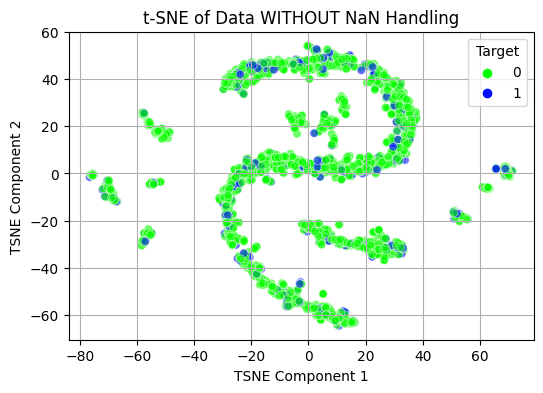

t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling


In [0]:
print("t-SNE Visualization for Data WITHOUT NaN Handling")
preprocess_and_tsne_with_nan_handling(X_valid, y_valid, 't-SNE of Data WITHOUT NaN Handling')

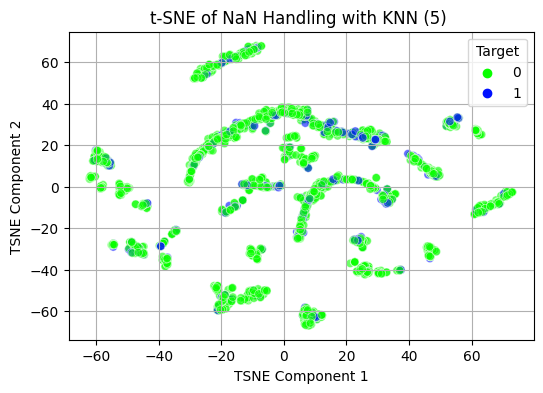

t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling


In [0]:
preprocess_and_tsne_with_nan_handling(X_valid_knn_imputed_5, y_valid, 't-SNE of NaN Handling with KNN (5) ')

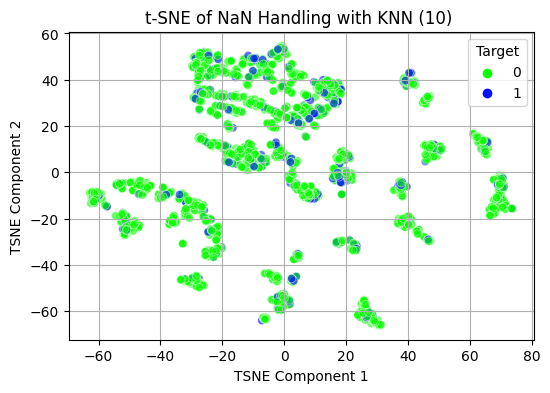

t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling


In [0]:
preprocess_and_tsne_with_nan_handling(X_valid_knn_imputed_10, y_valid, 't-SNE of NaN Handling with KNN (10) ')

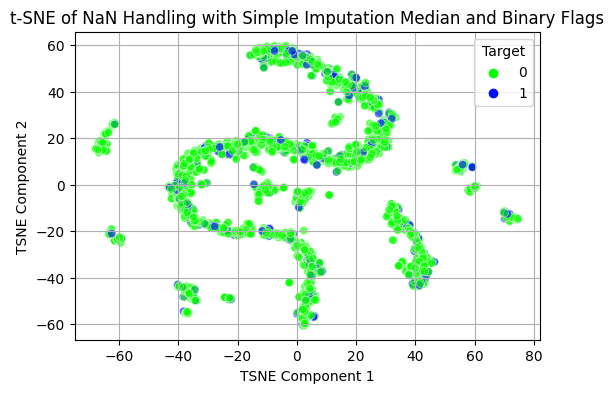

t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling


In [0]:
preprocess_and_tsne_with_nan_handling(X_valid_imputed, y_valid, 't-SNE of NaN Handling with Simple Imputation Median and Binary Flags')

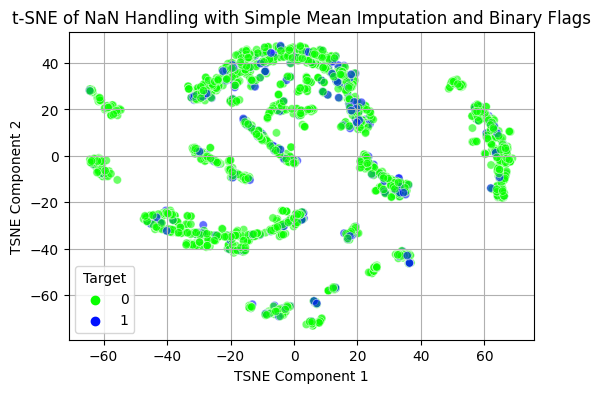

t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling


In [0]:
preprocess_and_tsne_with_nan_handling(X_valid_imputed_average, y_valid, 't-SNE of NaN Handling with Simple Mean Imputation and Binary Flags')

Observation: The visualization reveals more distinct patterns when we implement the Mean Target NaN Imputation method. We will proceed to quantitatively evaluate and compare the performance metrics of this approach in the following section to verify if the observed visual distinctions translate into improved predictive accuracy.

### Post-Imputation Model Evaluation:

In [0]:
# Function to evaluate and print metrics
def evaluate_model(name, y_true, y_pred, y_pred_probs):
    auc_score = roc_auc_score(y_true, y_pred_probs)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"--- {name} ---")
    print(f"AUC: {auc_score:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

%md
Imputed KNN 5 neighbours

In [0]:
model_mean = LGBMClassifier(random_state=1)
# Fit the model
model_mean.fit(X_train_knn_imputed_5, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_mean.predict_proba(X_valid_knn_imputed_5)[:, 1]
y_valid_pred = model_mean.predict(X_valid_knn_imputed_5)

# Evaluate the model
name='lightGBM with NaN KNN 5 neighbours Inputed'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)


--- lightGBM with NaN KNN 5 neighbours Inputed ---
AUC: 0.7646
Precision: 0.5781
Recall: 0.0923
Accuracy: 0.8697
F1 Score: 0.1591

The stability score on the train set is: 0.8112734011382797
The stability score on the valid set is: 0.16352155583177344


Imputed KNN 10 neighbours


In [0]:
model_mean = LGBMClassifier(random_state=1)
# Fit the model
model_mean.fit(X_train_knn_imputed_10, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_mean.predict_proba(X_valid_knn_imputed_10)[:, 1]
y_valid_pred = model_mean.predict(X_valid_knn_imputed_10)

# Evaluate the model
name='lightGBM with NaN Mean Target Inputed'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)


--- lightGBM with NaN Mean Target Inputed ---
AUC: 0.7807
Precision: 0.5758
Recall: 0.0948
Accuracy: 0.8697
F1 Score: 0.1627

The stability score on the train set is: 0.8112734011382797
The stability score on the valid set is: -0.028288709030278414


We see that the accuracy slightly drops and that the recall is dropping as well. As we see that the positive targets are spread around the space when imputing the mean of the neihbourgs we are pulling from the sourranding non positive class, which makes it even more difficult to distinguish. 

Imputed Median Simple Imputer and Numerical Missing Binary Flag

In [0]:
model_median = LGBMClassifier(random_state=1)
# Fit the model
model_median.fit(X_train_imputed, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_median.predict_proba(X_valid_imputed)[:, 1]
y_valid_pred = model_median.predict(X_valid_imputed)

# Evaluate the model
name='lightGBM with NaN Imputer Median Simple Imputer and Binary Flag'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)


--- lightGBM with NaN Imputer Median Simple Imputer and Binary Flag ---
AUC: 0.7820
Precision: 0.5057
Recall: 0.1097
Accuracy: 0.8667
F1 Score: 0.1803

The stability score on the train set is: 0.8168764453298893
The stability score on the valid set is: 0.1073786805247357


The Recall seems to decrease as we are reducing the information on extreme values which seems relevant for predicting the positive class

Imputed Mean Simple Imputer and Numerical Missing Binary Flag

In [0]:
model_mean = LGBMClassifier(random_state=1)
# Fit the model
model_mean.fit(X_train_imputed_average, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_mean.predict_proba(X_valid_imputed_average)[:, 1]
y_valid_pred = model_mean.predict(X_valid_imputed_average)

# Evaluate the model
name='lightGBM with NaN Imputer Mean Simple Imputer and Binary Flag'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

--- lightGBM with NaN Imputer Mean Simple Imputer and Binary Flag ---
AUC: 0.7784
Precision: 0.5128
Recall: 0.1235
Accuracy: 0.8658
F1 Score: 0.1990



Observation: By employing Mean Imputation combined with the addition of a Binary Flag for missing values, we observe a slight improvement in recall. This indicates that the Mean Imputation method, complemented by the Binary Flag, provides the model with more informative features regarding the presence of missing data. The Binary Flag helps by capturing and encoding the presence of null values for each case, which can be crucial for pattern recognition.

Notably, Mean Imputation yields better results in this context compared to Median Imputation. Although the median is generally more robust to outliers, in this scenario, the extreme values—retained and utilized by the mean method—hold significant predictive information that contributes to the model's performance.

# 3. Standardization of the Data

We need to standardize the data before applying the variation threshold and other more complex transformations.

We will compare between Standard Scaler and Robust Scaler (robust to outliers using statistics like median and interquantile range).

In [0]:
X_test_imputed_average.shape

(2000, 5628)

In [0]:
# Initialize RobustScaler
robust_scaler = RobustScaler()
std_scaler = StandardScaler()


# Fit and transform on training data, transform on validation data
X_train_scaled_robust = robust_scaler.fit_transform(X_train_imputed_average)
X_valid_scaled_robust = robust_scaler.transform(X_valid_imputed_average)

X_train_scaled_std = std_scaler.fit_transform(X_train_imputed_average)
X_valid_scaled_std = std_scaler.transform(X_valid_imputed_average)
X_test_scaled_std = std_scaler.transform(X_test_imputed_average)


# Convert back to DataFrame
X_train_scaled_robust = pd.DataFrame(X_train_scaled_robust, columns=X_train_imputed_average.columns)
X_valid_scaled_robust = pd.DataFrame(X_valid_scaled_robust, columns=X_valid_imputed_average.columns)

X_train_scaled_std = pd.DataFrame(X_train_scaled_std, columns=X_train_imputed_average.columns)
X_valid_scaled_std = pd.DataFrame(X_valid_scaled_std, columns=X_valid_imputed_average.columns)
X_test_scaled_std = pd.DataFrame(X_test_scaled_std, columns=X_test_imputed_average.columns)


Let's check the model performance, we do not expect a drastic change because the tree based model are not highly affected by the scale of the features. We are doing scaling to be able to apply other distance based dimension reduction methods

In [0]:
model_scaled_robust = LGBMClassifier(random_state=1)
# Fit the model
model_scaled_robust.fit(X_train_scaled_robust, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_scaled_robust.predict_proba(X_valid_scaled_robust)[:, 1]
y_valid_pred = model_scaled_robust.predict(X_valid_scaled_robust)

# Evaluate the model
name='lightGBM with Scaled Features with Robust Scaler'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

--- lightGBM with Scaled Features with Robust Scaler ---
AUC: 0.7765
Precision: 0.5000
Recall: 0.1142
Accuracy: 0.8650
F1 Score: 0.1859



In [0]:
model_scaled = LGBMClassifier(random_state=1)
# Fit the model
model_scaled.fit(X_train_scaled_std, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_scaled.predict_proba(X_valid_scaled_std)[:, 1]
y_valid_pred = model_scaled.predict(X_valid_scaled_std)

# Evaluate the model
name='lightGBM with Scaled Features with StandardScaler Scaler'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)


--- lightGBM with Scaled Features with StandardScaler Scaler ---
AUC: 0.7799
Precision: 0.4730
Recall: 0.1080
Accuracy: 0.8633
F1 Score: 0.1759



Observation: After applying scaling to the data, we notice a degradation in the model's performance. This decline may be attributed to the scaling process diminishing the impact of outliers, which, as previously identified, hold critical information for predicting the positive class.

Next Steps: We will next explore the impact of dimensionality reduction techniques. This will help us determine if reducing the number of dimensions can enhance the model's predictive power, potentially offsetting the negative effects observed post-scaling.

# 4. Threshold Variance

We apply threshold variance so the dimensionality algorithms are faster to compute. 

In [0]:
# Apply VarianceThreshold to remove low-variance features
varianceThreshold = VarianceThreshold(threshold=0.1)
X_train_reduced = varianceThreshold.fit_transform(X_train_scaled_std)
X_valid_reduced = varianceThreshold.transform(X_valid_scaled_std)
X_test_reduced = varianceThreshold.transform(X_test_scaled_std)

In [0]:
print('Shape training dataset before threshold variance', X_train_scaled_std.shape)
print('Shape training dataset after threshold variance', X_train_reduced.shape)

Shape training dataset before threshold variance (5600, 3752)
Shape training dataset after threshold variance (5600, 3418)


We reduce the dataset on 300 columns aproximately

# 5. Dimensionality Reduction Algorithms


Dimensionality Reduction Algorithms

1. Principal Component Analysis (PCA)

Description: PCA is a linear dimensionality reduction technique that transforms the data into a set of orthogonal components that capture the maximum variance.
Advantages:
Handles large datasets efficiently.
Reduces dimensionality while retaining as much variance as possible.
Limitations:
Assumes linear relationships.
May not perform well if the data is not linearly separable.
Suitability: Good for initial dimensionality reduction, especially when combined with other methods.

2. Linear Discriminant Analysis (LDA)

Description: LDA is a supervised technique that maximizes the separation between multiple classes.
Advantages:
Focuses on maximizing class separability.
Useful for classification tasks.
Limitations:
Assumes normally distributed classes with equal covariance matrices.
Limited to supervised settings.
Suitability: Best when the goal is to enhance class separability, especially in classification problems.

3. t-Distributed Stochastic Neighbor Embedding (t-SNE)

Description: t-SNE is a non-linear technique that visualizes high-dimensional data in lower dimensions by preserving local similarities.
Advantages:
Excellent for visualizing clusters.
Captures non-linear relationships.
Limitations:
Computationally intensive.
Primarily used for visualization rather than feature reduction for modeling.
Suitability: Best for visualizing complex patterns and clusters.

We apply PCA and again we visualize with t-SNE

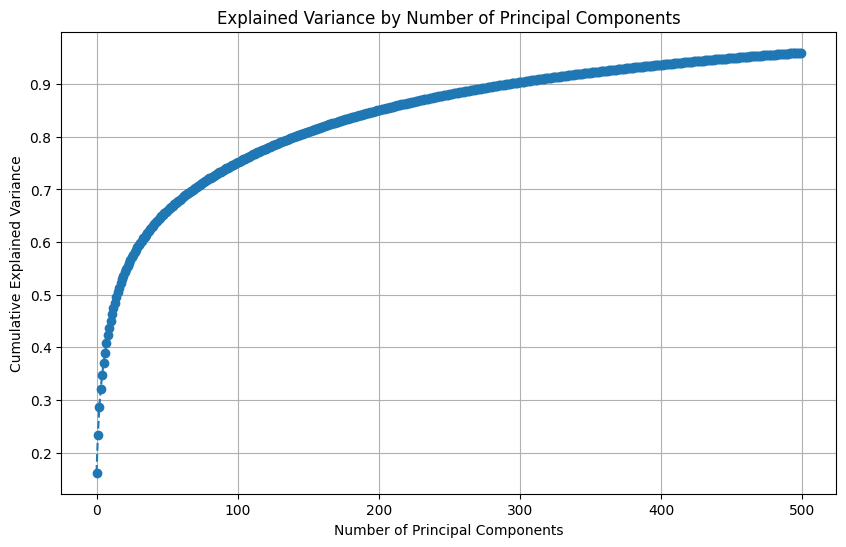

In [0]:
# Apply PCA on scaled and reduced training data
pca = PCA(n_components=500)  
X_train_reduced_pca = pca.fit_transform(X_train_reduced)
X_valid_reduced_pca = pca.transform(X_valid_reduced)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)
plt.show()

We would like to keep 95% of explained variance, so we would transform the space into 500 principal componenets

In [0]:
# Function to preprocess data, handle NaNs, and apply t-SNE
def tsne_plot(X, y, title):
    # Copy the dataset to avoid changing the original
    X_encoded = X.copy()
        
    # Initialize and apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(X_encoded)
    
    # Create a DataFrame with t-SNE results and target
    tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df['target'] = y.reset_index(drop=True)
    
    # Plot the t-SNE results
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        x='TSNE1', y='TSNE2',
        hue='target',
        palette=sns.color_palette('hsv', len(tsne_df['target'].unique())),
        data=tsne_df,
        alpha=0.3

    )
    plt.title(title)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Target')
    plt.grid(True)
    plt.show()

    print("t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling")

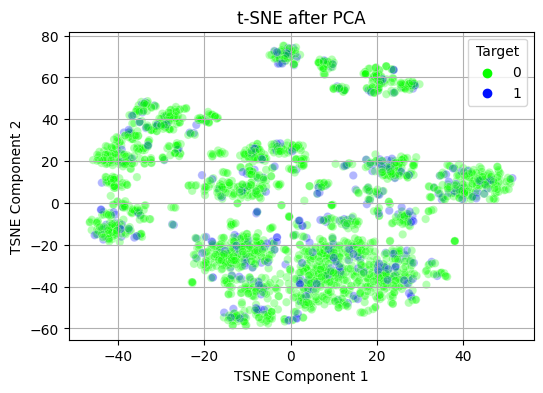

t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling


In [0]:
tsne_plot(X_valid_reduced_pca, y_valid, 't-SNE after PCA')


We see that after PCA it is visually not easier to distinguish between both classes/

Using other dimensionality Reduction Algorithm LDA: Linear Discriminant Analysis.

Number of Components=min(Number of Classes−1,Number of Features)

In [0]:
# Apply LDA on training data
lda = LDA(n_components=1)  # n_components based on the number of classes
X_train_reduced_lda = lda.fit_transform(X_train_reduced, y_train)
X_valid_reduced_lda = lda.transform(X_valid_reduced)
X_test_reduced_lda = lda.transform(X_test_reduced)

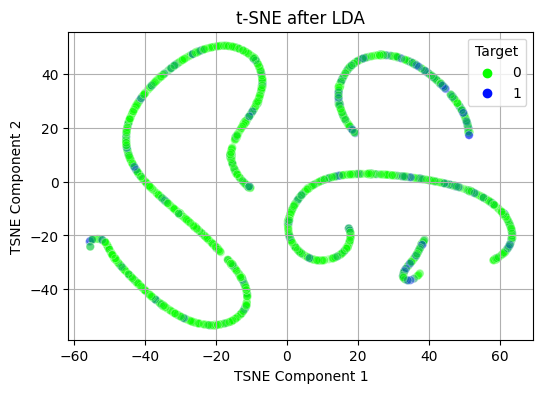

t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling


In [0]:
tsne_plot(X_valid_reduced_lda, y_valid, 't-SNE after LDA')

### Post-Dimensionality Reduction Evaluation:

Purpose: Evaluate how dimensionality reduction affects model performance looking at the classification metrics.

In [0]:
model_reduced = LGBMClassifier(random_state=1)
# Fit the model
model_reduced.fit(X_train_reduced_lda, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_reduced.predict_proba(X_valid_reduced_lda)[:, 1]
y_valid_pred = model_reduced.predict(X_valid_reduced_lda)

# Evaluate the model
name='lightGBM with Scaled Features with StandardScaler Scaler and LDA'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

--- lightGBM with Scaled Features with StandardScaler Scaler and LDA ---
AUC: 0.7071
Precision: 0.3965
Recall: 0.2818
Accuracy: 0.8467
F1 Score: 0.3294

The stability score on the train set is: 0.7246640826652294
The stability score on the valid set is: -0.03913611889690205


Observation: When compared to the baseline model, we observe an overall improvement in the results. However, there is a noticeable lack of stability in the validation set. To address this, we plan to incorporate regularization techniques into the LightGBM model to enhance its generalization capabilities.

Next Steps: In the final stages of model building, we will conduct a comparative analysis of the model's performance with and without applying LDA (Linear Discriminant Analysis) for dimensionality reduction. Although we anticipate some improvement in performance metrics through the sequential application of our preprocessing steps, we are cautious about the potential downsides of reducing the dataset to a single dimension. Such a significant reduction could impair the model's ability to learn complex patterns and relationships among features, as the data would be represented by a single composite feature. This could, in turn, diminish the predictive power of the model. We aim to validate this hypothesis in the forthcoming steps.

# 6. Handling Class inbalance applying  SMOTE on training data

In [0]:
# Apply SMOTE on training data after LDA 
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reduced_lda, y_train)


# Apply SMOTE on training data without LDA, high dimensions (hd)
smote_hd = SMOTE(random_state=42)
X_train_resampled_hd, y_train_resampled_hd = smote_hd.fit_resample(X_train_reduced, y_train)


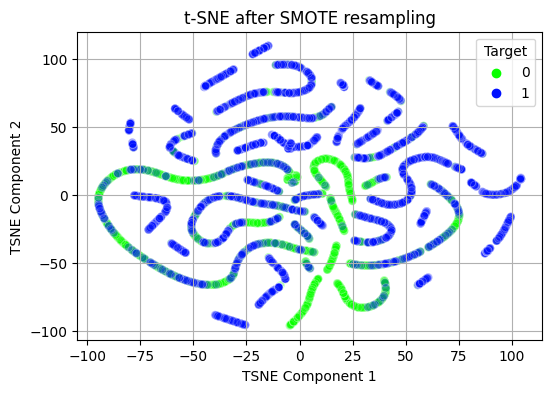

t-SNE Visualization for Mean and Mode Imputed Validation Data with NaN Handling


In [0]:
tsne_plot(X_train_resampled, y_train_resampled, 't-SNE after SMOTE resampling')

We check with the visualization that the number of samples from the positive class has increased after the SMOTE process

### SMOTE evaluation Evaluation:


We check the performance of SMOTE after the LDA dimensionality reduction step.

In [0]:
model_balanced = LGBMClassifier(random_state=1)
# Fit the model
model_balanced.fit(X_train_resampled, y_train_resampled)

# Predict probabilities and classes
y_valid_pred_probs = model_balanced.predict_proba(X_valid_reduced_lda)[:, 1]
y_valid_pred = model_balanced.predict(X_valid_reduced_lda)

# Evaluate the model
name='lightGBM with Scaled Features with StandardScaler Scaler and LDA and SMOTE'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

--- lightGBM with Scaled Features with StandardScaler Scaler and LDA and SMOTE ---
AUC: 0.6611
Precision: 0.2318
Recall: 0.5000
Accuracy: 0.7087
F1 Score: 0.3167



We check the performance after the SMOTE withouth the LDA step 

In [0]:
model_balanced = LGBMClassifier(random_state=1)
# Fit the model
model_balanced.fit(X_train_resampled_hd, y_train_resampled_hd)

# Predict probabilities and classes
y_valid_pred_probs = model_balanced.predict_proba(X_valid_reduced)[:, 1]
y_valid_pred = model_balanced.predict(X_valid_reduced)

# Evaluate the model
name='lightGBM with Scaled Features with StandardScaler Scaler and SMOTE'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

--- lightGBM with Scaled Features with StandardScaler Scaler and SMOTE ---
AUC: 0.7767
Precision: 0.4719
Recall: 0.1296
Accuracy: 0.8629
F1 Score: 0.2034



Observation: The application of SMOTE has shown improved performance following all our preprocessing transformations, with the exception of dimensionality reduction. This suggests that the data, when maintained in its fuller dimensionality, better supports the synthetic oversampling process and enhances model accuracy.

Decision: Based on these findings, we will proceed with these transformations, excluding dimensionality reduction, for our final model configuration. This approach should optimize our model’s ability to accurately predict outcomes by preserving the essential characteristics of the data.

We will try to optimize both, the traning data with and without LDA reduction to F1. We get better reuslts after applyin LDA but we want to make sure that that is still the case after applying hyperparameter tunning

# 7. Final Model Evaluation after adding hyperparameter tunning and Regularization

Optimizing the model withouth the LDA transformation on F1 score

In [0]:
# LightGBM hyperparameters grid for tuning
param_grid = {
  'num_leaves': [20, 31, 40, 50, 60],
  'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
  'n_estimators': [100, 200, 300, 400, 500],
  'max_depth': [-1, 10, 15, 20, 25],
  'min_child_weight': [1, 3, 5, 7],
  'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
  'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
  'reg_alpha': [0.0, 0.1, 0.5, 1.0],
  'reg_lambda': [0.0, 0.1, 0.5, 1.0],
  'objective': ['binary', 'tweedie']
}

# Initialize the LGBMClassifier
model = LGBMClassifier(random_state=1)

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    scoring='f1',
    n_iter=50,  # Number of parameter settings sampled
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1,
    verbose=2,
    random_state=1
)

# Fit the model
random_search.fit(X_train_resampled_hd, y_train_resampled_hd)

# Get the best model
best_model_hd = random_search.best_estimator_

# Predict probabilities and classes
y_valid_pred_probs = best_model_hd.predict_proba(X_valid_reduced)[:, 1]
y_valid_pred = best_model_hd.predict(X_valid_reduced)

# Evaluate the tuned model
name = 'LightGBM with Scaled Features with StandardScaler, SMOTE, Regularization and Randomized Hyperparameter Tuning'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
--- LightGBM with Scaled Features with StandardScaler, SMOTE, Regularization and Randomized Hyperparameter Tuning ---
AUC: 0.7655
Precision: 0.4638
Recall: 0.0988
Accuracy: 0.8629
F1 Score: 0.1628



Optimizing the model with the LDA transformation on F1 score

In [0]:
# LightGBM hyperparameters grid for tuning
param_grid = {
  'num_leaves': [20, 31, 40, 50, 60],
  'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
  'n_estimators': [100, 200, 300, 400, 500],
  'max_depth': [-1, 10, 15, 20, 25],
  'min_child_weight': [1, 3, 5, 7],
  'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
  'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
  'reg_alpha': [0.0, 0.1, 0.5, 1.0],
  'reg_lambda': [0.0, 0.1, 0.5, 1.0],
  'objective': ['binary', 'tweedie']
}

# after first iteration we make the grid closer to the best params and re-train
param_grid_second_round = {
  'num_leaves': [40, 50, 60, 70],
  'learning_rate': [0.1, 0.15, 0.2],
  'n_estimators': [150, 200, 250],
  'max_depth': [5, 10, 15],
  'min_child_weight': [1, 3],
  'subsample': [0.6, 0.7, 0.8],
  'colsample_bytree': [0.7, 0.8, 0.9],
  'reg_alpha': [0.1, 0.2, 0.5],
  'reg_lambda': [0.1, 0.3, 0.5, 1.0],
  'objective': ['binary', 'tweedie']
}

# Initialize the LGBMClassifier
model = LGBMClassifier(random_state=1)

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid_second_round,
    scoring='f1',
    n_iter=50,  # Number of parameter settings sampled
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1,
    verbose=2,
    random_state=1
)

# Fit the model
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model_rd = random_search.best_estimator_

# Predict probabilities and classes
y_valid_pred_probs = best_model_rd.predict_proba(X_valid_reduced_lda)[:, 1]
y_valid_pred = best_model_rd.predict(X_valid_reduced_lda)

# Evaluate the tuned model
name = 'LightGBM with Scaled Features with StandardScaler, LDA, SMOTE, Regularization and Randomized Hyperparameter Tuning'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
--- LightGBM with Scaled Features with StandardScaler, LDA, SMOTE, Regularization and Randomized Hyperparameter Tuning ---
AUC: 0.6605
Precision: 0.2370
Recall: 0.4907
Accuracy: 0.7179
F1 Score: 0.3196



In [0]:
### Saving the best model
# Specify the path to save the model
model_path = '/dbfs/FileStore/LEM_TEST/best_lightgbm_model_rd.joblib'

# Save the model
joblib.dump(best_model_rd, model_path)

['/dbfs/FileStore/LEM_TEST/best_lightgbm_model_rd.joblib']

We conducted a comparative analysis of two LightGBM models optimized using Randomized Hyperparameter Tuning, each processed with 5-fold cross-validation on 50 candidates, totaling 250 fits for each model. The primary difference between the models is the inclusion of Linear Discriminant Analysis (LDA) in one of the models.

- Model with LDA (Dimensionality Reduction):
Configuration: Scaled features with StandardScaler, LDA for dimensionality reduction, SMOTE for handling class imbalance, and regularization. This model demonstrates a higher recall and F1 score, suggesting better performance in identifying the positive class. The inclusion of LDA likely enhances class separability, which is crucial for datasets with overlapping class distributions. However, this comes at the expense of precision and overall accuracy.


- Model without LDA: Scaled features with StandardScaler, SMOTE, and regularization. Although this model exhibits higher overall accuracy and precision, its significantly lower recall and F1 score indicate it struggles with correctly identifying as many positive cases as the model with LDA.

Conclusion:
The model incorporating LDA presents a better balance in terms of recall and F1 score, which are critical when the cost of missing positive cases is high. This suggests that the dimensionality reduction not only simplifies the model but potentially exposes more meaningful features that aid in distinguishing between classes. For applications where identifying the positive class is prioritized over the precise classification of all samples, the LDA-inclusive model is preferable.


### Regularization Comments

In [0]:
best_model_rd

LGBMClassifier(colsample_bytree=0.9, max_depth=5, min_child_weight=3,
               n_estimators=200, num_leaves=50, objective='tweedie',
               random_state=1, reg_alpha=0.5, reg_lambda=1.0, subsample=0.6)


**L1 Penalty**  reg_alpha adds a penalty equivalent to the absolute value of the magnitude of coefficients (L1 penalty) to the loss function.
It  Encourages sparsity, meaning it can drive some coefficients to zero. Helps in feature selection by potentially eliminating less important features.

Best model Value: reg_alpha=0.5. Moderate L1 Regularization: A value of 0.5 indicates a moderate level of L1 regularization, encouraging sparsity but not too aggressively.

**L2 Penalty** reg_lambda adds a penalty equivalent to the square of the magnitude of coefficients (L2 penalty) to the loss function. Penalizes large coefficients more heavily.
Helps in reducing model complexity and overfitting.

Best model Value:  reg_lambda=1. A value of 1 indicates a standard level of L2 regularization, providing a balanced regularization effect.

# 6. Test Performance

Evaluating the performance of the final model in the test set, the out of sample set. 

In [0]:
# Predict probabilities and classes
y_test_pred_probs = best_model_rd.predict_proba(X_test_reduced_lda)[:, 1]
y_test_pred = best_model_rd.predict(X_test_reduced_lda)

# Evaluate the model
name='lightGBM with Scaled Features with StandardScaler Scaler and LDA and SMOTE'
evaluate_model(name, y_test, y_test_pred, y_test_pred_probs)

--- lightGBM with Scaled Features with StandardScaler Scaler and LDA and SMOTE ---
AUC: 0.6489
Precision: 0.2157
Recall: 0.4574
Accuracy: 0.7155
F1 Score: 0.2932



### Analysis of Test Results Performance Metrics

Model Configuration: LightGBM with features scaled using StandardScaler, variance threshold, incorporating Linear Discriminant Analysis (LDA) for dimensionality reduction and SMOTE for handling class imbalance.

Metrics Comparison with the basic baseline (random weight model):

 - AUC (Area Under the Curve):  Observation: The AUC has decreased from 0.78 to 0.6489. Implication: The reduced AUC suggests a decreased overall ability to discriminate between positive and negative classes compared to the baseline. The transformations and balancing may have impacted the model’s general discrimination negatively but improved class separability.

- Precision:  Observation: Precision has decreased from 0.53 to 0.2157. Implication: The significant drop in precision indicates an increase in false positives, which can be attributed to the model's sensitivity to the synthetic minority samples generated by SMOTE, potentially leading to overfitting to the minority class characteristics.

- Recall: Observation: Recall has significantly increased from 0.13 to 0.4574.  Implication: This substantial improvement over the baseline model's recall indicates that the model modifications have successfully made it more capable of identifying true positives, which is particularly advantageous in applications where detecting positive cases is paramount.

- Accuracy: Observation: Accuracy has decreased from 0.86 to 0.7155. Implication: This decrease aligns with the strategic shift towards prioritizing the detection of positive cases (recall) over overall prediction accuracy. The model accepts a higher false positive rate to ensure fewer false negatives, which is a typical trade-off in imbalanced datasets.
F1 Score:

- Observation: The F1 Score has improved from 0.21 to 0.2932. Implication: Although the model shows lower precision, the improvement in the F1 Score indicates a better balance between precision and recall compared to the baseline. The model, despite less precision, proves to be more effective for the specific needs of handling imbalanced data.


## Interpretation and Potential Reasons for changes: 
- Imputation: Adding binary flags for missing data added extra information, helping the model distinguish between observed and missing data points more effectively.
- Dimensionality Reduction: LDA maximized class separability, it contributed to improvements in recall and precision by creating a more distinct separation between classes.
- Re-Sampling: SMOTE balanced the dataset by generating synthetic samples for the minority class, providing the model with more balanced training data. It reduced the model bias towards the majority class.
- Regularization: model parameters (reg_alpha and reg_lambda) helped control overfitting, ensuring the model generalized better to unseen data. 


# Conclusion

Compared to the baseline, the tested model with LDA and SMOTE demonstrates a strategic adaptation towards improving recall, crucial for detecting positive cases in applications with high costs associated with false negatives. While this has resulted in decreased precision and overall accuracy, the model's capacity to identify true positives more effectively makes it suitable for specialized contexts where class imbalances significantly impact performance. Model accuracy is still low, could not be productivized because we will discard a high number of non positive cases. 
